# Simulating the formation of myosin clusters
In this notebook, I constructed a simple toy model to simulate the growth of myosin clusters via accretion. 

There are a series of random grids where myosin could bind (indices `0` to `numGrid`)

Each grid is initialized with an initial number of myosin & F-actin density.

In each iteration, a single myosin lands on a random grid based on a probability distribution, which is proportional to a) the F-actin density, and/or b) existing number of myosin on that grid. 

Repeat the process until all myosin have landed to a grid.

In [1]:
# Import packages
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from random import choices
import seaborn as sns
import random
from scipy.spatial import Delaunay
from numpy.random import default_rng
import pandas as pd
#import networkx as nx


## 1D myosin binding simulation

### Setting up the simulation

In [2]:
# Define function that generates the underlying actin distribution
def GenActinThick(method, numGrid, *keys):
    rng = default_rng()
    if method == 'lognormal':
        ## Passed argument should be mu and sigma
        (mu, sigma) = keys
        ActinThick = rng.lognormal(mu, sigma, (numGrid))
    elif method == 'normal':
        ## Passed argument should be loc and scale
        (loc, scale) = keys
        ActinThick = rng.normal(loc, scale, (numGrid))
    elif method == 'uniform':
        ## Passed argument should be low and high
        (low, high) = keys
        ActinThick = rng.uniform(low, high, (numGrid))
    elif method == 'poisson':
        ## Passed argument should be lambda
        lam = keys
        ActinThick = rng.poisson(lam, (numGrid))
    else:
        raise ValueError('Method not supported!')
    return ActinThick#.astype(int)

# Define function that generates the initial myosin cluster size
def GenMyoNum(method, numMyosin, *keys):
    rng = default_rng()
    if method == 'lognormal':
        ## Passed argument should be mu and sigma
        (mu, sigma) = keys
        myosinNum = rng.lognormal(mu, sigma, (numMyosin))
    elif method == 'normal':
        ## Passed argument should be loc and scale
        (loc, scale) = keys
        myosinNum = rng.normal(loc, scale, (numMyosin))
    elif method == 'uniform':
        ## Passed argument should be low and high
        (low, high) = keys
        myosinNum = rng.uniform(low, high, (numMyosin))
    elif method == 'poisson':
        ## Passed argument should be lambda
        lam = keys
        myosinNum = rng.poisson(lam, (numMyosin))
    else:
        raise ValueError('Method not supported!')
    return myosinNum#.astype(int)

# Define function that runs simulation based on weights that are defined
def runSimulation(numGrid, numMyosin, MyosinInit, ActinInit, actinBiasVal, myosinBiasVal, ifsave, dwnsample):
    ### numGrid: number of grid points
    ### numMyosin: number of new myosin filaments to bind
    ### MyosinNum: initial myosin cluster size
    ### ActinThick: initial F-actin density
    ### actinBiasVal, myosinBiasVal: degree of affinity for new myosin to bind to actin or myosin

    MyosinNum = MyosinInit.copy()
    ActinThick = ActinInit.copy()
    
    if ifsave:
        MyosinNumHist = np.zeros((numGrid, int(numMyosin/dwnsample)))

    # Define probability weights and draw random grid number that myosin lands
    for ii in range(numMyosin):
        index = np.arange(0, numGrid)
        actinBias = ActinThick * actinBiasVal
        myosinBias = MyosinNum * myosinBiasVal
        weights = np.ones((numGrid)) + actinBias + myosinBias
        #weights = weights * np.exp(-MyosinNum/ActinThick/myoCap)
        weights = weights/np.sum(weights) #* np.exp(-np.maximum(0, np.array(MyosinNum)-myoCap))     ## Binding probability exponentially decays if exceeds binding capacity
        #weights[np.array(MyosinNum)>=myoCap] = 0   ###!!!!!!! Anything site that exceed capacity can't bind
        if len(np.nonzero(weights)[0]) == 0:    ### Terminate if no more available sites
            break
        else:
            landing = choices(index, weights)
            MyosinNum[landing] = MyosinNum[landing] + 1
        
        if ifsave:
            if ii%dwnsample == 0:
                MyosinNumHist[:, ii//dwnsample] = MyosinNum.T

    if ifsave:
        return MyosinNum, MyosinNumHist
    else:
        return MyosinNum

In [69]:
ActinThick = GenActinThick('lognormal', 10, 1.62, 0.48)
MyosinInit = GenMyoNum('lognormal', 10, 1.31, 0.52) 
actinBiasVal=100
myosinBiasVal=0
actinBias = ActinThick * actinBiasVal
myosinBias = MyosinInit * myosinBiasVal
weights = np.ones((10)) + actinBias + myosinBias
weights = weights/np.sum(weights)
print(ActinThick)



[5.88222517 9.40983192 4.08725587 6.12839572 3.8182169  3.73516065
 6.22115416 2.64092315 7.0872693  5.84406872]


In [ ]:
    #### Archaic codes
        #numMerger = numGrid*activity
        #if numMerger>0 and numMerger<1:
        #    numMerger = np.random.random_sample()<numMerger
        
        #if numMerger > 0.0:
        #    numMerger = round(numMerger)
        #    merger_id = np.random.randint(0, numGrid-1, (numMerger))
        #    for edges in merger_id:
        #        MyosinNum[edges]=MyosinNum[edges]+MyosinNum[edges+1]
        #        MyosinNum[edges+1]=-1
        #        ActinThick[edges]=ActinThick[edges]+ActinThick[edges+1]
        #        ActinThick[edges+1]=-1
        #    MyosinNum = MyosinNum[MyosinNum!=-1]
        #    #print(MyosinNum.shape)
        #    ActinThick = ActinThick[ActinThick!=-1]
        #    #print(ActinThick.shape)
        #    numGrid -= numMerger

        #diff = np.abs(MyosinNum[1:] - MyosinNum[0:-1])
        #merge_cand = np.where(diff>merge_thresh)[0]
        #for jj in merge_cand:
        #    if np.random.rand()<Pmerge:
        #        (mergeId, tomerge) = (jj, jj+1)
        #        if MyosinNum[jj]<MyosinNum[jj+1]:
        #            (mergeId, tomerge) = (jj+1, jj)
        #        MyosinNum[mergeId]=MyosinNum[mergeId]+MyosinNum[tomerge]
        #        MyosinNum[tomerge]=0
        #        ActinThick[jj]=ActinThick[jj]+ActinThick[tomerge]
        #        ActinThick[tomerge]=1

        #if dis_rate > 0.0:
        #    numDisassemble = math.floor(dis_rate)
        #    if (dis_rate-numDisassemble) > np.random.random_sample():
        #        numDisassemble += 1
        #    dis_prob = np.array(MyosinNum) * np.exp(-np.array(MyosinNum))
        #    count = 0
        #    while count < numDisassemble:
        #        dis_id = choices(index, dis_prob)
        #        MyosinNum[dis_id] = 0
        #        count += 1

### Visualize initial conditions to be used

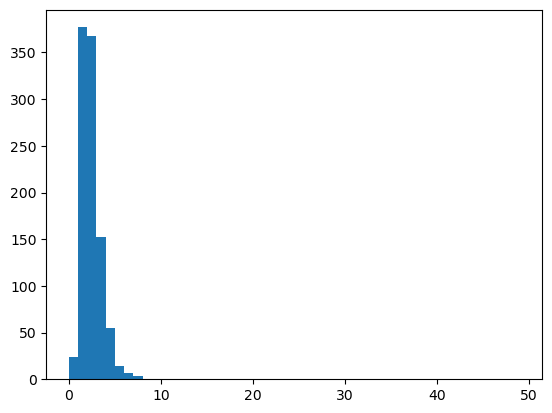

7


In [4]:
lognormNum = GenMyoNum('lognormal', 1000, 1.8, 0.6)
lognormNum1 = GenMyoNum('lognormal', 1000, 0.8, 0.4)
gaussNum = GenMyoNum('normal', 1000, 3, 0.6)
plt.hist(lognormNum1, bins = np.arange(50))
plt.show()

In [3]:
# Load experimental data
allPointDataYB = pd.read_csv('allPointData_YB.csv')
allPointDataYB.head()

,labels,x,y,intensity
0,cell1,373.529876,878.947456,3539.935224
1,cell1,381.585359,882.036750,4665.215992
2,cell1,381.609805,887.437442,5115.323621
3,cell1,382.596995,903.567588,1868.539465
4,cell1,383.381948,897.635095,2517.216225


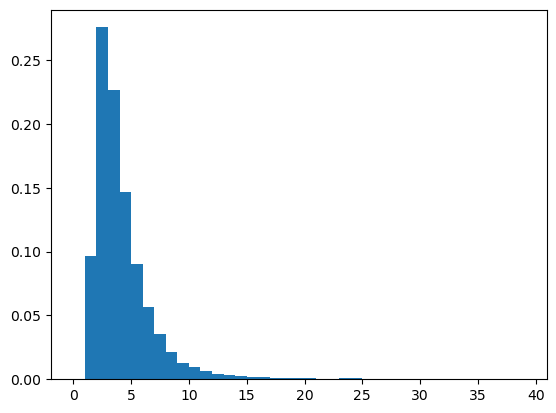

In [4]:
# "Size" distribution of Y+B+ experiments
for ii in allPointDataYB['labels'].unique():
    allInt_sub = allPointDataYB[allPointDataYB['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntYB = normInt.copy()
    else:
        allIntYB = pd.concat([allIntYB, normInt.copy()], ignore_index=True)
#print(allPointDataYB['labels'].unique())
#allPointDataYB['intensity']/np.min(allPointDataYB['intensity'])
plt.hist(allIntYB, bins = np.arange(40), density = True)
plt.show()

In [6]:
(s, loc, scale) = st.lognorm.fit(allIntYB, floc = 0)
print('Using experimental conditions, the initial lognormal distribution for the simulation should have mu:', np.log(scale), ', and  should be:', s)

Using experimental conditions, the initial lognormal distribution for the simulation should have mu: 1.3097472527725154 , and  should be: 0.5204161226594383


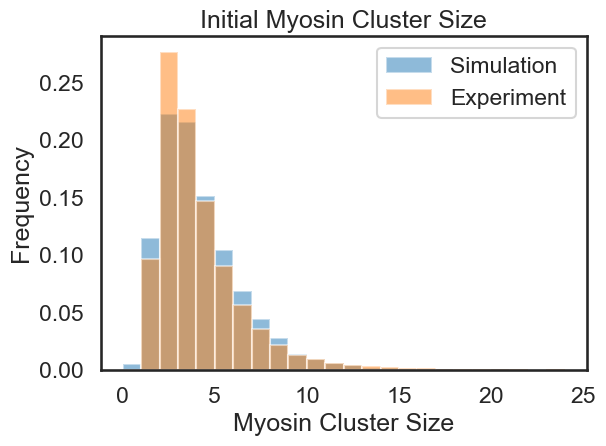

In [32]:
lognormNum1 = GenMyoNum('lognormal', 10000, 1.31, 0.52)
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(lognormNum1, bins = np.arange(25), density = True, alpha = 0.5, label = 'Simulation')
plt.hist(allIntYB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Experiment')
plt.title('Initial Myosin Cluster Size')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('Initial cluster size.png')

In [33]:
print(np.sum(lognormNum1))

42723.53981937957


### Test visulization

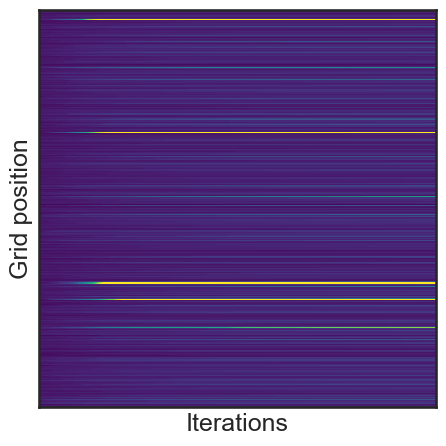

In [76]:
# Kymograph
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = .5
myosinBiasVal = .5
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

plt.figure()
plt.imshow(myoHist, cmap = 'viridis', vmin=0, vmax=40)
plt.xticks([])
plt.yticks([])
plt.xlabel('Iterations')
plt.ylabel('Grid position')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_kymograph_acBias_half_myoBias_half')

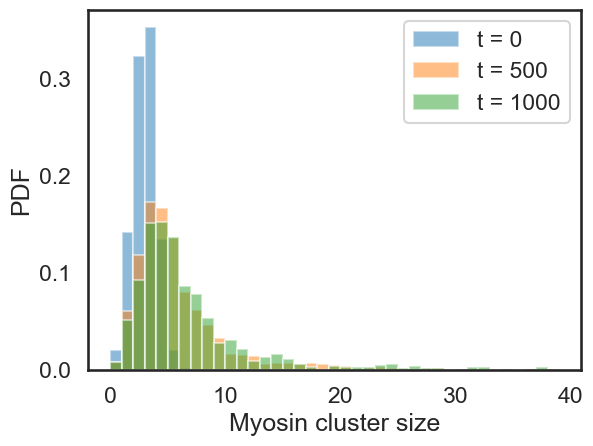

In [80]:
# Evolution of histogram
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = .5
myosinBiasVal = .5
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(myoHist[:,0], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 0')
plt.hist(myoHist[:,499], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 500')
plt.hist(myoHist[:,999], bins = np.arange(40), density = True, alpha = 0.5, label = 't = 1000')
plt.legend()
plt.xlabel('Myosin cluster size')
plt.ylabel('PDF')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_histoEvolve_acBias_half_myoBias_half')

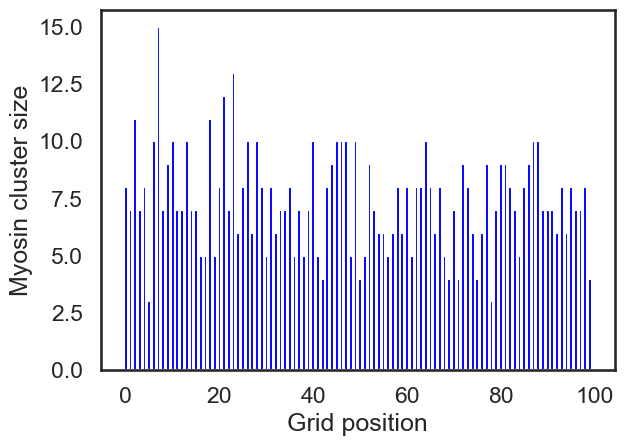

In [84]:
# Bar plot
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
#myoCap = 30
actinBiasVal = 0
myosinBiasVal = 0
res, myoHist = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, 1, 10)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.bar(np.arange(100), myoHist[:100,500], color = 'blue')
plt.xlabel('Grid position')
plt.ylabel('Myosin cluster size')
#plt.show()
plt.tight_layout()
plt.savefig('myosinBinding_bar_acBias_0_myoBias_0')

## Accretion with no bias towards myosin or actin

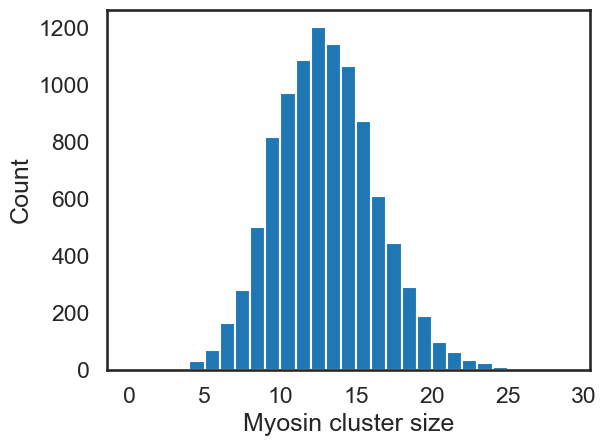

In [20]:
# Simulation ROCK-dependent cluster growth: no biases, random binding
numMyosin = 10000
numGrid = 1000
actinBiasVal = 0
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.
numSim = 10

allRes = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(30))
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.tight_layout()
#plt.savefig("myosinBinding_histogram_acBias_0_myoBias_0.png", dpi = 300)

## Accretion with myosin bias (Blebbistatin $\pm$ Y-27)

0.6028339650662288 0.0 5.226661191518827


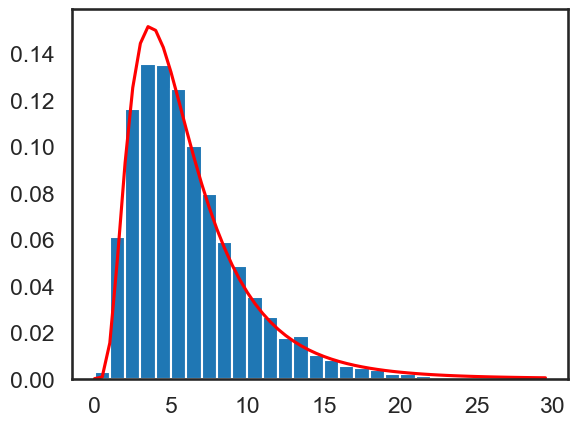

In [14]:
numMyosin = 20000
numGrid = 10000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 0
myosinBiasVal = 10
ifsave = 0
dwnsample = 1


# Initialize and run simulation
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal, ifsave, dwnsample)

allData = np.reshape(res, (numGrid))
(s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
print(s, loc, scale)
xfit = np.arange(0, 30, 0.5)
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allData, bins = np.arange(30), density = True)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')

#plt.xlabel("Myosin cluster size")
#plt.ylabel("Count")
#plt.legend()
#plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

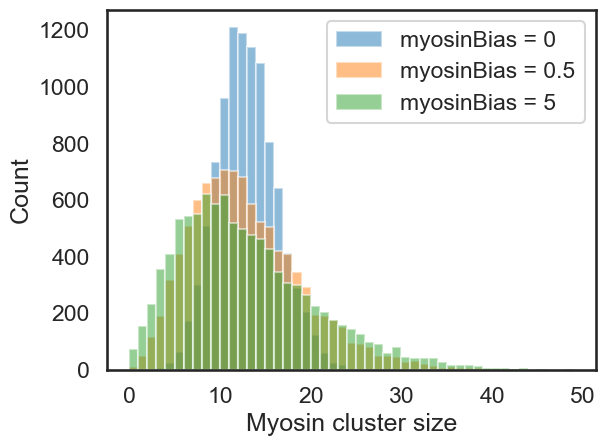

In [23]:
## Average over 10 simulations
# Simulation parameters
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 0
myosinBiasVal = [0, .5, 5]
merge_thresh = 100000000
Pmerge = 0.

numSim = 10

sns.set_style("white")
sns.set_context("talk")
plt.figure()
#plt.rcParams['font.size'] = '16'
for ii in range(len(myosinBiasVal)):
    # Scan through myosinBiasVal
    countRes = np.zeros((numSim, 80))
    allRes = np.zeros((numSim, numGrid))
    for jj in range(numSim):
        # Initialize and run simulation
        ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
        MyosinNum = GenMyoNum('normal', numGrid, 3, 1) 
        res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal[ii], merge_thresh, Pmerge)
        allRes[jj, :] = res   # Number of myosin particles
    plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = "myosinBias = " + str(myosinBiasVal[ii]))

plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

### Scan $\alpha$ to match with experimental conditions

In [5]:
# Load experimental data
allPointDataYoutB = pd.read_csv('allPointData_YoutB.csv')
allPointDataYoutB.head()

,labels,x,y,intensity
0,cell1,445.898295,848.799659,3120.365625
1,cell1,452.905939,852.814262,2517.818702
2,cell1,454.251963,848.456719,3118.491720
3,cell1,456.372308,813.807775,6305.371871
4,cell1,458.456133,824.918940,3814.982536


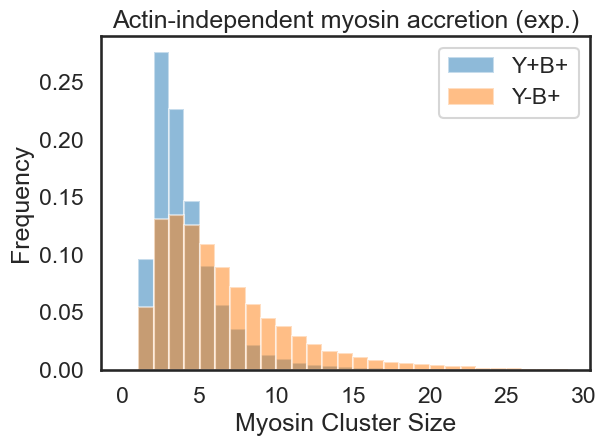

In [6]:
# "Size" distribution of Y+B+ experiments
for ii in allPointDataYoutB['labels'].unique():
    allInt_sub = allPointDataYoutB[allPointDataYoutB['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntYoutB = normInt.copy()
    else:
        allIntYoutB = pd.concat([allIntYoutB, normInt.copy()], ignore_index=True)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allIntYB, bins = np.arange(30), alpha=0.5, density=True, label='Y+B+')
plt.hist(allIntYoutB, bins = np.arange(30), alpha=0.5, density = True, label='Y-B+')
plt.title('Actin-independent myosin accretion (exp.)')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('YoutB.png')

In [75]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a, label):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post', label = label)
    plt.grid(True)

numMyosin = [30000]
numGrid = 10000
actinBiasVal = 0
myosinBiasVal = [5]
ifsave = 0
dwnsample = 1

#acBias = np.zeros((len(myosinBiasVal)))
#myoBias = np.zeros((len(myosinBiasVal)))
#mode_array = np.zeros((len(myosinBiasVal)))
#sigma_array = np.zeros((len(myosinBiasVal)))
# Initialize and run simulation

for ii in range(len(numMyosin)):
    for jj in range(len(myosinBiasVal)):
        ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
        MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 
        res = runSimulation(numGrid, numMyosin[ii], MyosinInit, ActinThick, actinBiasVal, myosinBiasVal[jj], ifsave, dwnsample)

        # Save mu, sigma
        allData = np.reshape(res, (numGrid))
        (s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
        #acBias[jj] = actinBiasVal
        #myoBias[jj] = myosinBiasVal[jj]
        #mode_array[jj] = np.exp(np.log(scale)-s**2)
        #sigma_array[jj] = s

        # Save histogram
        sns.set_style("white")
        sns.set_context("talk")
        plt.figure()
        xfit = np.arange(0, 30, 0.2)
        plt.hist(MyosinInit, bins = np.arange(30), alpha=0.5, density = True, label = 'Initial condition')
        plt.hist(res, bins = np.arange(30), alpha=0.5, density = True, label = 'numMyosin='+str(numMyosin[ii])+r', $\alpha$='+str(myosinBiasVal[jj]))
        plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.savefig('myosinBinding_histogram_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_'+str(myosinBiasVal[jj])+'_acBias_0.png', dpi = 300)
        plt.close()

        # Save CDF
        sns.set_style("white")
        sns.set_context("talk")
        plt.figure()
        plot_ecdf(allIntYoutB, 'Experiment')
        plot_ecdf(res, 'Simulation')
        plt.title('Cumulative distribution')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.savefig('myosinBinding_ecdf_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_'+str(myosinBiasVal[jj])+'_acBias_0.png', dpi = 300)
        plt.close()

#df = pd.DataFrame({'alpha': myoBias, 'beta': acBias, 'mode': mode_array, 'sigma': sigma_array})
#df.to_csv('params.csv')


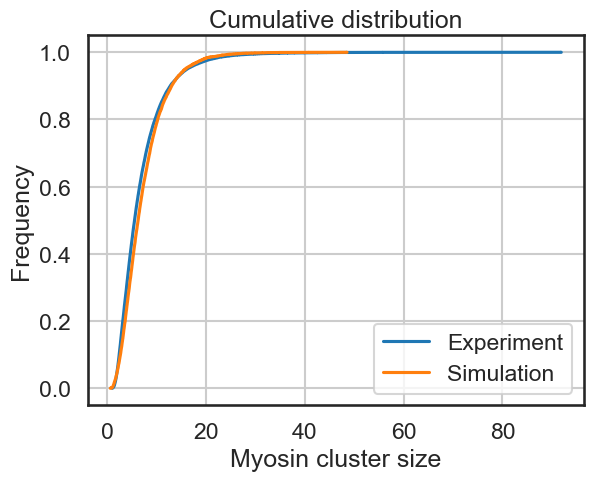

In [73]:
numMyosin = 30000
numGrid = 10000
actinBiasVal = 0
myosinBiasVal = 5
ifsave = 0
dwnsample = 1
ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) 

res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal, ifsave, dwnsample)

# Save histogram
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plot_ecdf(allIntYoutB, 'Experiment')
plot_ecdf(res, 'Simulation')
plt.title('Cumulative distribution')
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()

## Accretion with both myosin & F-actin bias (blebbistatin vs control)

### Initial conditions

In [7]:
allPointDataBB = pd.read_csv('allPointDataBB.csv')
allPointDataBB.head()

,labels,x,y,intensity
0,cell1,183.271200,623.056458,2004.770497
1,cell1,183.866520,675.729873,2927.096330
2,cell1,184.361366,688.352109,2228.139469
3,cell1,190.513000,625.742408,2759.057944
4,cell1,193.046247,720.858748,3596.843203


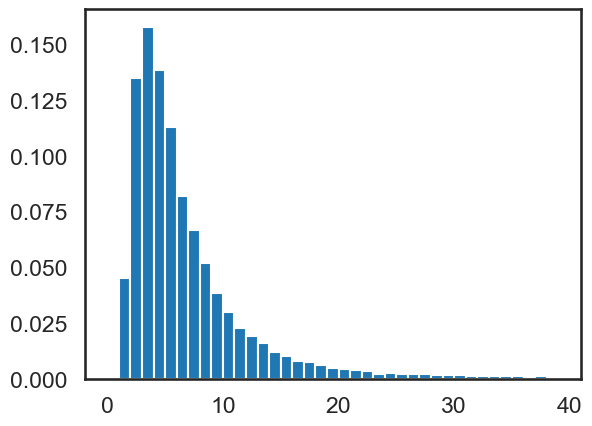

In [8]:
# "Size" distribution of blebbistatin experiments
for ii in allPointDataBB['labels'].unique():
    allInt_sub = allPointDataBB[allPointDataBB['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntBB = normInt.copy()
    else:
        allIntBB = pd.concat([allIntBB, normInt.copy()], ignore_index=True)
#print(allPointDataYB['labels'].unique())
#allPointDataYB['intensity']/np.min(allPointDataYB['intensity'])
plt.hist(allIntBB, bins = np.arange(40), density = True)
plt.show()

In [22]:
(s, loc, scale) = st.lognorm.fit(allIntBB, floc = 0)
print('Using experimental conditions, the initial lognormal distribution for the simulation should have mu:', np.log(scale), ', and sigma should be:', s)

Using experimental conditions, the initial lognormal distribution for the simulation should have mu: 1.7307717427442268 , and sigma should be: 0.7003005502092207


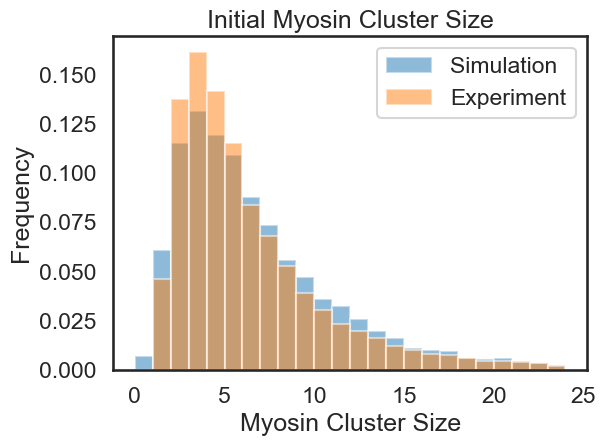

In [53]:
lognormNum2 = GenMyoNum('lognormal', 10000, 1.73, 0.7)
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(lognormNum2, bins = np.arange(25), density = True, alpha = 0.5, label = 'Simulation')
plt.hist(allIntBB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Experiment')
plt.title('Initial Myosin Cluster Size')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('Initial cluster size_bleb.png')

In [54]:
print(np.sum(lognormNum2))

71927.1591642635


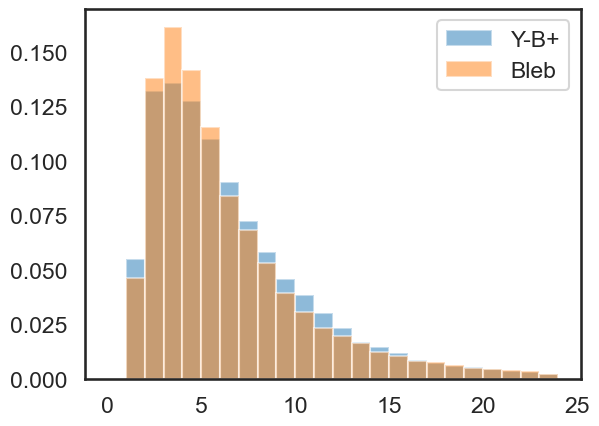

In [20]:
### Compare Y-B+ and only blebbistatin
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allIntYoutB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Y-B+')
plt.hist(allIntBB, bins = np.arange(25), density = True, alpha = 0.5, label = 'Bleb')
plt.legend()
plt.show()

### Initial conditions for F-actin density

In [16]:
allBundleInt = pd.read_csv('allBundleInt_WT.csv')
allBundleInt.head()

,labels,int_arr
0,cell1,2332
1,cell1,2332
2,cell1,2309
3,cell1,2309
4,cell1,2312


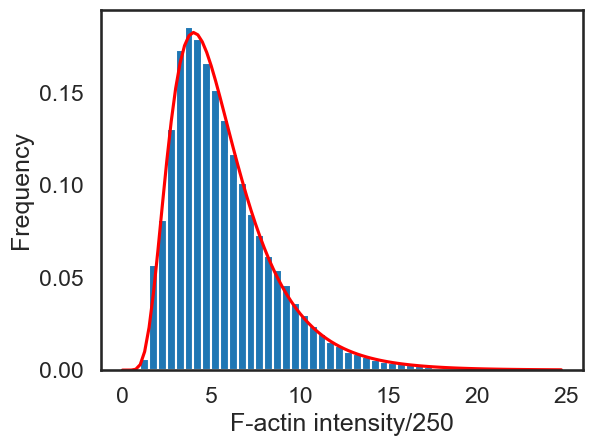

In [51]:
(s, loc, scale) = st.lognorm.fit(allBundleInt['int_arr']/250, floc = 0)
plt.figure()
plt.hist(allBundleInt['int_arr']/250, bins = np.arange(0, 25, 0.5), density = True)
xfit = np.arange(0, 25, 0.25)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.xlabel('F-actin intensity/250')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
plt.savefig('Initial_actin')

In [49]:
print('After scaling, the F-actin density is fitted to a lognormal with mu = ', np.log(scale), ' and sigma = ', s)

After scaling, the F-actin density is fitted to a lognormal with mu =  1.6233542902018876  and sigma =  0.48368810447717353


### Scan $\beta$ to match experimental conditions

In [9]:
# Load experimental data
allPointDataWT = pd.read_csv('allPointDataWT.csv')
allPointDataWT.head()

,labels,x,y,intensity
0,cell1,133.103870,778.926337,3370.810842
1,cell1,133.951202,753.215117,9084.421618
2,cell1,138.152704,760.248273,1635.657255
3,cell1,141.762984,778.100500,15486.452430
4,cell1,145.103032,790.611341,1692.924150


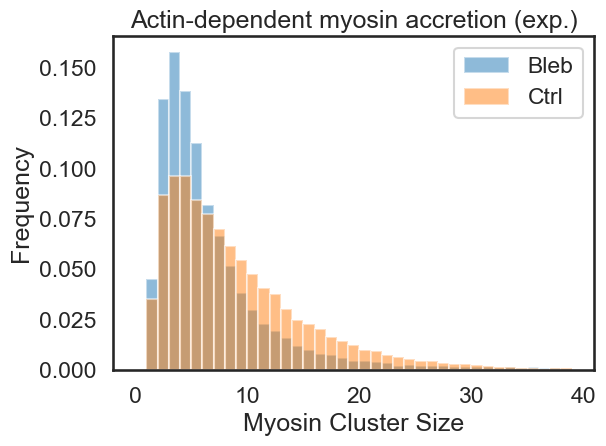

In [10]:
# "Size" distribution of Y+B+ experiments
for ii in allPointDataWT['labels'].unique():
    allInt_sub = allPointDataWT[allPointDataWT['labels']==ii]
    normInt = allInt_sub['intensity']/np.min(allInt_sub['intensity'])
    if ii == 'cell1':
        allIntWT = normInt.copy()
    else:
        allIntWT = pd.concat([allIntWT, normInt.copy()], ignore_index=True)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allIntBB, bins = np.arange(40), alpha=0.5, density=True, label='Bleb')
plt.hist(allIntWT, bins = np.arange(40), alpha=0.5, density = True, label='Ctrl')
plt.title('Actin-dependent myosin accretion (exp.)')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('BB_ctrl.png')

In [11]:
#### Define functions that calculate CDF and plot CDF
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a, label):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post', label = label)
    plt.grid(True)

In [88]:
# Scan parameters to recapitulate experimental results
numMyosin = [10000, 20000, 30000]
numGrid = 10000
actinBiasVal = [0, 0.5, 1, 5, 10]
myosinBiasVal = 5
ifsave = 0
dwnsample = 1

#acBias = np.zeros((len(myosinBiasVal)))
#myoBias = np.zeros((len(myosinBiasVal)))
#mode_array = np.zeros((len(myosinBiasVal)))
#sigma_array = np.zeros((len(myosinBiasVal)))
# Initialize and run simulation

for ii in range(len(numMyosin)):
    for jj in range(len(actinBiasVal)):
        ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
        MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
        res = runSimulation(numGrid, numMyosin[ii], MyosinInit, ActinThick, actinBiasVal[jj], myosinBiasVal, ifsave, dwnsample)

        # Save CDF
        sns.set_style("white")
        sns.set_context("talk")
        plt.figure()
        plot_ecdf(allIntWT, 'Experiment')
        plot_ecdf(res, 'numMyosin='+str(numMyosin[ii])+r', $\beta$='+str(actinBiasVal[jj]))
        plt.title('Cumulative distribution')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.savefig('myosinBinding_ecdf_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_5_acBias_'+str(actinBiasVal[jj])+'.png', dpi = 300)
        plt.close()

        # Save mu, sigma
        allData = np.reshape(res, (numGrid))
        (s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
        #acBias[jj] = actinBiasVal
        #myoBias[jj] = myosinBiasVal[jj]
        #mode_array[jj] = np.exp(np.log(scale)-s**2)
        #sigma_array[jj] = s

        # Save histogram
        sns.set_style("white")
        sns.set_context("talk")
        plt.figure()
        xfit = np.arange(0, 40, 0.5)
        plt.hist(MyosinInit, bins = np.arange(40), alpha=0.5, density = True, label = 'Initial condition')
        plt.hist(res, bins = np.arange(40), alpha=0.5, density = True, label = 'numMyosin='+str(numMyosin[ii])+r', $\beta$='+str(actinBiasVal[jj]))
        plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.savefig('myosinBinding_histogram_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_5_acBias_'+str(actinBiasVal[jj])+'.png', dpi = 300)
        plt.close()

#df = pd.DataFrame({'alpha': myoBias, 'beta': acBias, 'mode': mode_array, 'sigma': sigma_array})
#df.to_csv('params.csv')


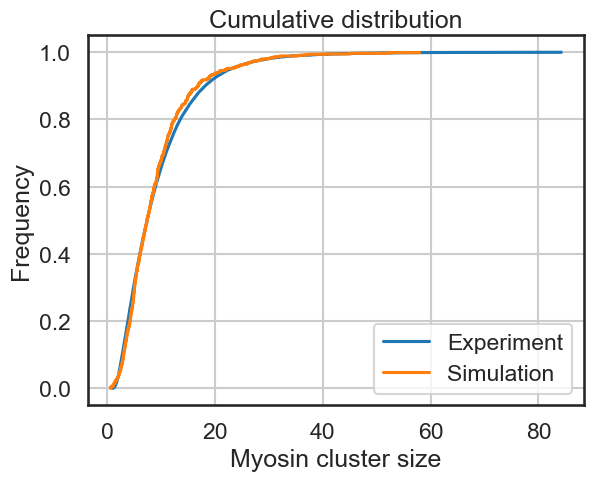

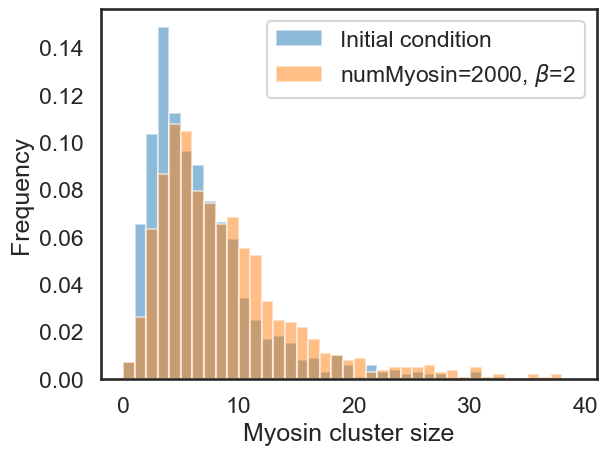

In [87]:
numMyosin = 2000
numGrid = 1000
actinBiasVal = 2
myosinBiasVal = 5
ifsave = 0
dwnsample = 1

ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal, myosinBiasVal, ifsave, dwnsample)
# CDF
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plot_ecdf(allIntWT, 'Experiment')
plot_ecdf(res, 'Simulation')
plt.title('Cumulative distribution')
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()
# Histogram
sns.set_style("white")
sns.set_context("talk")
plt.figure()
xfit = np.arange(0, 40, 0.5)
plt.hist(MyosinInit, bins = np.arange(40), alpha=0.5, density = True, label = 'Initial condition')
plt.hist(res, bins = np.arange(40), alpha=0.5, density = True, label = 'numMyosin='+str(numMyosin)+r', $\beta$='+str(actinBiasVal))
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()


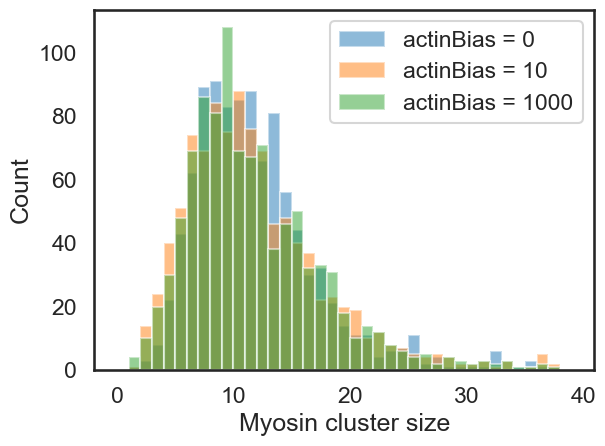

In [83]:
## Run simulation
# Simulation parameters
numMyosin = 5000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = [0, 10, 1000]
myosinBiasVal = 0
ifsave=0
dwnsample=1


sns.set_style("white")
sns.set_context("talk")
plt.figure()
#plt.rcParams['font.size'] = '16'
for ii in range(len(actinBiasVal)):
    # Run simulations
    ActinThick = GenActinThick('lognormal', numGrid, 1.62, 0.48)
    MyosinInit = GenMyoNum('lognormal', numGrid, 1.73, 0.7) 
    res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[ii], myosinBiasVal, ifsave, dwnsample)

    plt.hist(res, bins = np.arange(40), alpha = 0.5, label = "actinBias = " + str(actinBiasVal[ii]))

plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_myoBias_0_mu_1_sigma_1_actinBiasComp.png", dpi = 300)

## Dependence on F-actin distribution

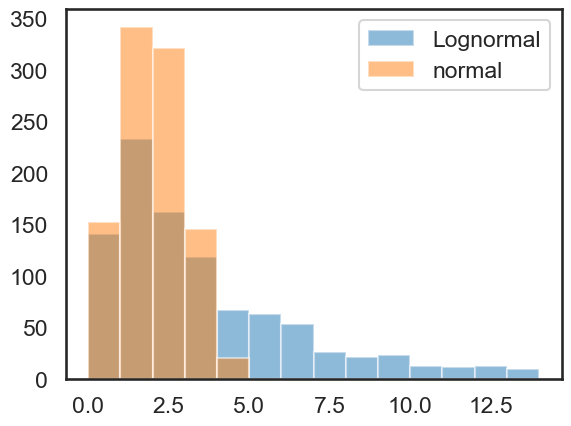

In [26]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'Lognormal')
plt.hist(GenActinThick('normal', numGrid, 2, 1), bins = np.arange(15), alpha = 0.5, label = 'normal')
#plt.hist(GenActinThick('uniform', numGrid, 0, 10), bins = np.arange(15), alpha = 0.5, label = 'normal')
plt.legend()
#plt.savefig("actin_dist_comp.png", dpi = 300)

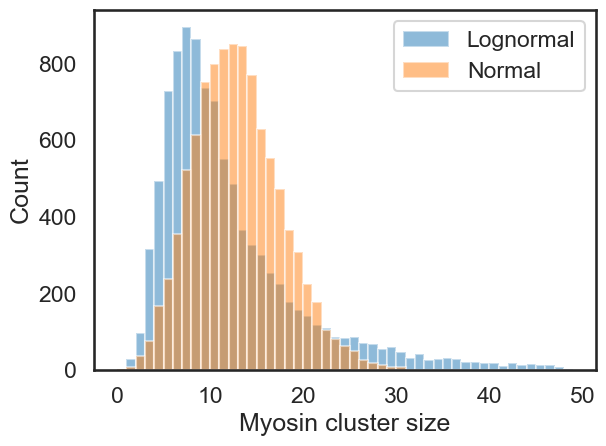

In [28]:
## Run simulation
# Simulation parameters
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 1
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.

numSim = 10
    
allRes_LN = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_LN[ii, :] = res

allRes_N = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('normal', numGrid, 2, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_N[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(np.reshape(allRes_LN, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = 'Lognormal')
plt.hist(np.reshape(allRes_N, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = 'Normal')
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
#plt.savefig("", dpi = 300)

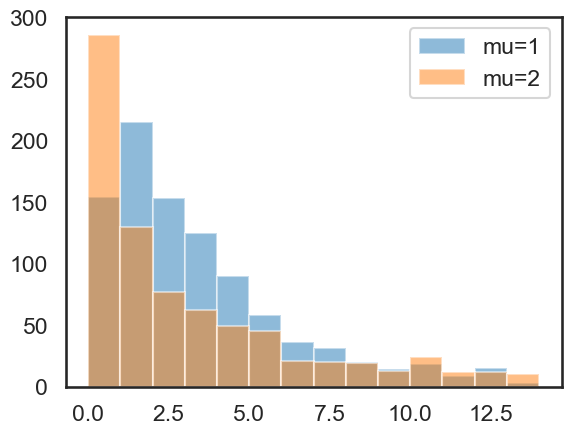

In [31]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'mu=1')
#plt.hist(GenActinThick('lognormal', numGrid, 1, 0.5), bins = np.arange(15), alpha = 0.5, label = 'mu=0.5')
plt.hist(GenActinThick('lognormal', numGrid, 1, 2), bins = np.arange(15), alpha = 0.5, label = 'mu=2')
plt.legend()
plt.savefig("actin_dist_comp.png", dpi = 300)

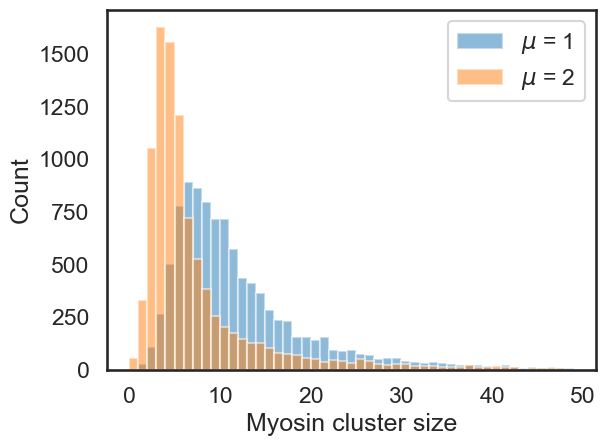

In [32]:
numMyosin = 10000
numGrid = 1000
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 1
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.

numSim = 10
    
allRes_1 = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_1[ii, :] = res

allRes_2 = np.zeros((numSim, numGrid))
for ii in range(numSim):
    ActinThick = GenActinThick('lognormal', numGrid, 1, 2)
    MyosinNum = GenMyoNum('normal', numGrid, 3, 1)
    res = runSimulation(numGrid, numMyosin, MyosinNum, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes_2[ii, :] = res

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(np.reshape(allRes_1, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = '$\mu$ = 1')
plt.hist(np.reshape(allRes_2, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = '$\mu$ = 2')
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("myosinBinding_histogramComp_myoBias_0_actinBias_1_mu_1_sigmaComp.png", dpi = 300)

## Actomyosin correlation

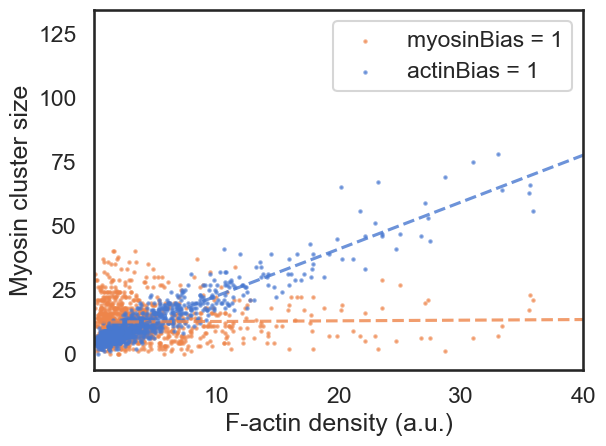

In [113]:
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
#myoCap = 1000   # Cap the number of myosin per site
merge_thresh = 100000000
Pmerge = 0.
numMyosin = 10000
numGrid = 1000

# Run simulations
resAcBias = runSimulation(numMyosin, numGrid, ActinThick, 1, 0, merge_thresh, Pmerge)
resMyoBias = runSimulation(numMyosin, numGrid, ActinThick, 0, 1, merge_thresh, Pmerge)

acFit = st.linregress(ActinThick, resAcBias)
myoFit = st.linregress(ActinThick, resMyoBias)

sns.set_style("white")
sns.set_context("talk")
co = sns.color_palette('muted')
xt = np.arange(ActinThick.max())
plt.figure()
plt.scatter(ActinThick, resMyoBias, s = 3, color=co[1], alpha = 0.6, label = 'myosinBias = 1')
plt.plot(xt, myoFit.intercept+myoFit.slope*xt, '--', color=co[1], alpha = 0.8)
plt.scatter(ActinThick, resAcBias, s = 3, color=co[0], alpha = 0.6, label = 'actinBias = 1')
plt.plot(xt, acFit.intercept+acFit.slope*xt, '--', color=co[0], alpha = 0.8)
#plt.rcParams['font.size'] = '16'
plt.xlabel("F-actin density (a.u.)")
plt.ylabel("Myosin cluster size")
plt.legend()
plt.xlim((0, 40))
plt.tight_layout()
plt.savefig("myosinBinding_actomyosinCorr_mu_1_sigma_1.png", dpi = 300)

## Coalescence

## Bias towards both F-actin and myosin

### Phase space

In [11]:
MyosinNum = GenMyoNum('normal', numGrid, 3, 1) 
sum(MyosinNum)

2498

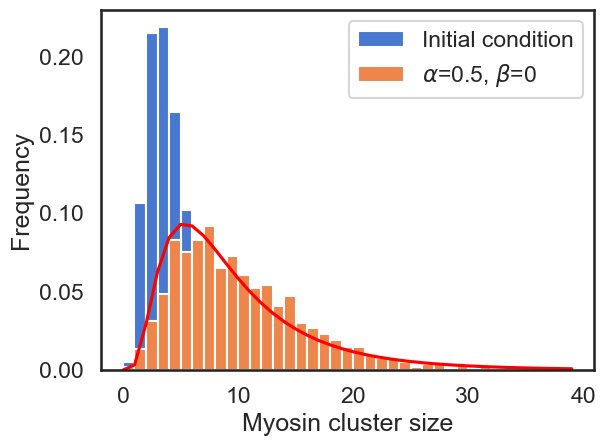

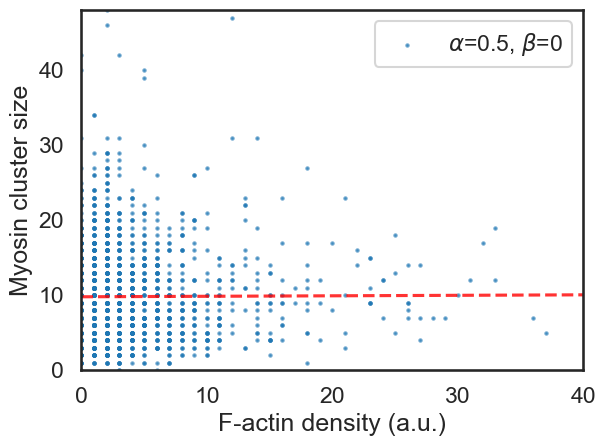

In [60]:
numMyosin = 12000
numGrid = 2000
actinBiasVal = [0]
myosinBiasVal = [0.5]
ifsave = 0
dwnsample = 1

acBias = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
myoBias = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
mode_array = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
sigma_array = np.zeros((len(actinBiasVal)*len(myosinBiasVal)))
# Initialize and run simulation
for ii in range(len(actinBiasVal)):
    for jj in range(len(myosinBiasVal)):
        ActinThick = GenActinThick('lognormal', numGrid, 1, 1)
        MyosinInit = GenMyoNum('lognormal', numGrid, 1.31, 0.52) #GenMyoNum('normal', numGrid, 3, 0.6) 
        res = runSimulation(numGrid, numMyosin, MyosinInit, ActinThick, actinBiasVal[ii], myosinBiasVal[jj], ifsave, dwnsample)

        # Save goodness of fit metrics
    

        # Save mu, sigma
        allData = np.reshape(res, (numGrid))
        (s, loc, scale) = st.lognorm.fit(allData[allData>0], floc = 0)
        idx = ii*len(actinBiasVal)+jj
        acBias[idx] = actinBiasVal[ii]
        myoBias[idx] = myosinBiasVal[jj]
        mode_array[idx] = np.exp(np.log(scale)-s**2)
        sigma_array[idx] = s

        # Save histogram
        sns.set_style("white")
        sns.set_context("talk")
        co = sns.color_palette('muted')
        plt.figure()
        xfit = np.arange(40)
        plt.hist(MyosinInit, bins = np.arange(40), color = co[0], density = True, label = 'Initial condition')
        plt.hist(allData, bins = np.arange(40), color = co[1], density = True, label = r'$\alpha$='+str(myosinBiasVal[jj])+r', $\beta$='+str(actinBiasVal[ii]))
        plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        #plt.savefig('myosinBinding_histogram_myoBias_'+str(myosinBiasVal[jj])+'_acBias_'+str(actinBiasVal[ii])+'.png', dpi = 300)
        #plt.close()
    
        # Save actomyosin correlation
        acFit = st.linregress(ActinThick, res)
        sns.set_style("white")
        sns.set_context("talk")
        xt = np.arange(ActinThick.max())
        plt.figure()
        plt.scatter(ActinThick, res, s = 3, alpha = 0.6, label = r'$\alpha$='+str(myosinBiasVal[jj])+r', $\beta$='+str(actinBiasVal[ii]))
        plt.plot(xt, acFit.intercept+acFit.slope*xt, '--', color='red', alpha = 0.8)
        plt.xlabel("F-actin density (a.u.)")
        plt.ylabel("Myosin cluster size")
        plt.xlim((0, 40))
        plt.ylim((0, min(np.max(res), 100)))
        plt.legend()
        plt.tight_layout()
        #plt.savefig('myosinBinding_actomyosinCorr_myoBias_'+str(myosinBiasVal[jj])+'_acBias_'+str(actinBiasVal[ii])+'.png', dpi = 300)
        #plt.close()

#df = pd.DataFrame({'alpha': myoBias, 'beta': acBias, 'mode': mode_array, 'sigma': sigma_array})
#df.to_csv('params.csv')
#plt.xlabel("Myosin cluster size")
#plt.ylabel("Count")
#plt.legend()
#plt.tight_layout()
#plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

In [54]:
df

,alpha,beta,mode,sigma
0,0.0,0.0,6.386863,0.332523
1,0.1,0.0,5.907304,0.402334
2,0.3,0.0,5.509874,0.459776
3,0.5,0.0,5.174711,0.503087
4,0.0,0.1,5.985740,0.389910
5,0.1,0.1,5.271528,0.475196
6,0.3,0.1,4.616913,0.551871
7,0.5,0.1,4.244361,0.601536
8,0.0,0.3,5.054862,0.502745
9,0.1,0.3,4.063147,0.581286


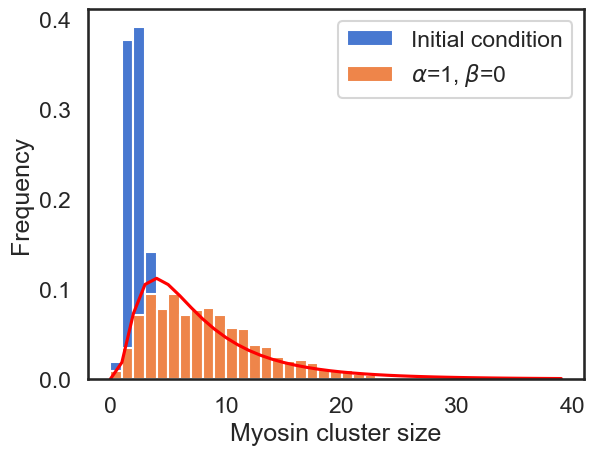

In [77]:
myosinBiasVal = 1
actinBiasVal = 0
res = runSimulation(2000, 12000, GenMyoNum('lognormal', 2000, 0.8, 0.4) , GenActinThick('lognormal', 2000, 1, 1), actinBiasVal, myosinBiasVal, 0, 1)
#res.tofile('myoNum.csv', sep=' ')
(s, loc, scale) = st.lognorm.fit(res[res>0], floc = 0)
sns.set_style("white")
sns.set_context("talk")
co = sns.color_palette('muted')
plt.figure()
xfit = np.arange(40)
plt.hist(GenMyoNum('lognormal', 2000, 0.8, 0.4), bins = np.arange(40), color = co[0], density = True, label = 'Initial condition')
plt.hist(res, bins = np.arange(40), color = co[1], density = True, label = r'$\alpha$='+str(myosinBiasVal)+r', $\beta$='+str(actinBiasVal))
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.xlabel("Myosin cluster size")
plt.ylabel("Frequency")
plt.legend()

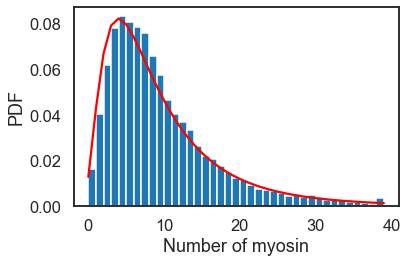

In [86]:
mu = 1   # Thickness of actin
sigma = 1
myoCap = 1000   # Cap the number of myosin per site
actinBias = .5
myosinBias = .3
numMyosin = 10000
numSim = 10

allRes = np.zeros((numSim, numGrid))
for ii in range(numSim):
    res = runSimulation(numMyosin, mu, sigma, myoCap, actinBias, myosinBias)
    allRes[ii, :] = res
    
allData = np.reshape(allRes, (numSim*numGrid))
(s, loc, scale) = st.lognorm.fit(allData, loc = 0)
xfit = np.arange(40)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
sns.set_style("white")
sns.set_context("talk")
plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(40), density = True, stacked = True)
plt.xlabel("Number of myosin")
plt.ylabel("PDF")
plt.tight_layout()
plt.savefig("myosinBinding_histogram_acBias_0.5_myoBias_0.3_mu_1_sigma_1.png", dpi = 300)

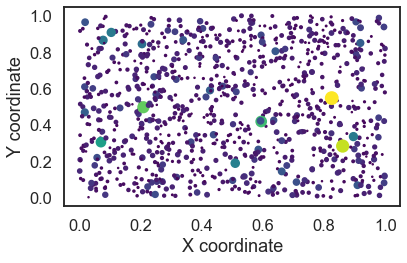

In [87]:
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_0.5_myoBias_0.3.png", dpi = 300)

3953.4968549675964
6868.177043360022
11161.516435368332


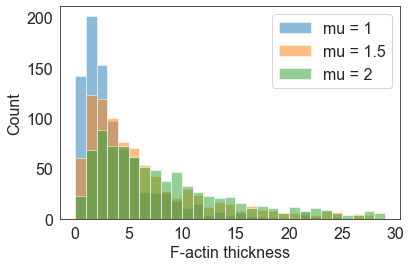

In [60]:
sigma = 1
for mu in [1,1.5,2]:
    thickness = np.random.lognormal(mu, sigma, 900)
    print(sum(thickness))
    plt.hist(thickness, alpha = 0.5, bins = np.arange(30), label = 'mu = '+str(mu))
plt.xlabel("F-actin thickness")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("Actin_thickness_muComp.png", dpi = 300)

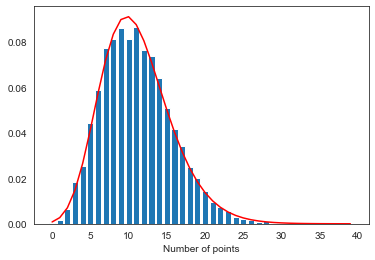

In [11]:
sns.set_style("white")
plt.figure()
allData = np.reshape(allRes, (numGrid*numGrid*10))
(s, loc, scale) = st.lognorm.fit(allData, loc = 0)
xfit = np.arange(40)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.bar(xfit, avgHist[0:40]/sum(avgHist))
plt.xlabel("Number of myosin")
plt.ylabel("PDF")
plt.savefig("myosinBinding_histogram_acBias_1_myoBias_0_lam_6.png", dpi = 300)

In [ ]:
sns.set_style("white")
plt.figure()
sns.histplot(np.reshape(MyosinPoints, (numGrid*numGrid)), binwidth = 1)
plt.xlabel("Number of points")
#plt.savefig("myosinBinding_histogram_acBias_1_myoBias_0.5.png", dpi = 300)
#plt.hist(np.reshape(MyosinPoints, (numGrid*numGrid)), bins = np.arange(np.max(MyosinPoints)))

## 2D case
In construction...

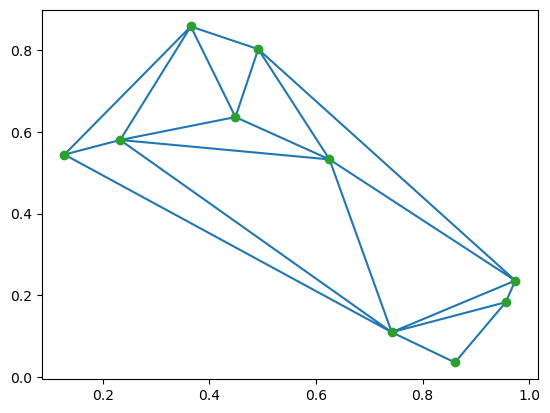

In [5]:
# Define initial network structure
numGrid = 10
coordinates = np.zeros((numGrid, 2))
for ii in range(numGrid):
    coordinates[ii, 0] = random.random()
    coordinates[ii, 1] = random.random()

tri = Delaunay(coordinates)
plt.triplot(coordinates[:,0], coordinates[:,1], tri.simplices)
plt.plot(coordinates[:,0], coordinates[:,1], 'o')
plt.show()

In [11]:
tri.simplices

array([[6, 5, 2],
       [3, 6, 7],
       [6, 3, 5],
       [3, 0, 5],
       [0, 7, 4],
       [0, 3, 7],
       [8, 9, 1],
       [0, 9, 5],
       [5, 9, 2],
       [9, 8, 2],
       [9, 0, 4]], dtype=int32)

In [10]:
coordinates.tolist()[0]

[0.2327347347226143, 0.5804723624457677]

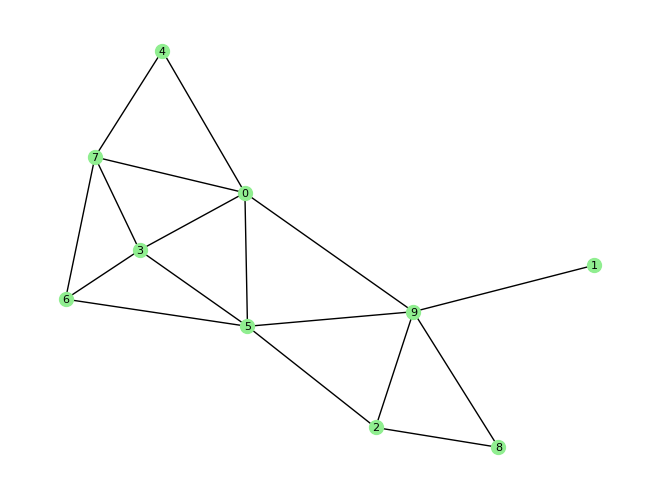

In [12]:
G = nx.Graph()
#G.add_nodes_from(coordinates.tolist())
for path in tri.simplices:
    nx.add_path(G, path)
    
nx.draw(G, with_labels=True, node_size=100, node_color='lightgreen', font_size=8)

In [5]:
tri.points[0]==coordinates[0,:]

array([ True,  True])

In [6]:
# Extract neighbors
vertex_id = 1
index_pointers, indices = tri.vertex_neighbor_vertices
result_id = indices[index_pointers[vertex_id]:index_pointers[vertex_id+1]]
result_id

array([983, 684, 436,  70, 398, 851], dtype=int32)

In [61]:
weights = np.array([.1, .2, .1, .4, .2, .3])
myoCap = 6
weights[np.array([3,5,2,7,4,2])>=myoCap] = weights[np.array([3,5,2,7,4,2])>=myoCap]*np.exp(-())
weights

array([0.1, 0.2, 0.1, 2. , 0.2, 0.3])